In [1]:
import pandas as pd
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sq

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from statistics import mean, stdev
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import model_selection

# Prepare Dataset

In [2]:
# import dataset
conn = sq.connect('C:/Users/Reza Fakhrurrozi/Documents/GitHub/PlatinumChallange-Group2-/database_pl.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
df = pd.read_sql_query(q_data, conn)
df.head(10)

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
5,makanan beragam harga makanan di food stall ak...,positive
6,pakai kartu kredit baca tidak untung malah rug...,negative
7,tempat unik bagus buat foto makanan enak pegaw...,positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [3]:
df['Label'].value_counts()

Label
positive    6383
negative    3412
neutral     1138
Name: count, dtype: int64

# Text Normalization

In [4]:
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [5]:
df['Tweet_Clean'] = df.Tweet.apply(cleansing)
df.head()

,Tweet,Label,Tweet_Clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatra bandung temp...,positive,lokasi strategis di jalan sumatra bandung temp...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative,aduh jadi mahasiswa jangan sombong dong kasih ...


In [6]:
# memfilter data berdasarkan label
df_positive = df[df['Label'] == 'positive']
df_negative = df[df['Label'] == 'negative']
df_neutral = df[df['Label'] == 'neutral']

# menyeimbangkan label netral dengan label negatif
df_neutral_over = df_neutral.sample(df_negative.shape[0], replace=True)

# menggabungkan semua data
df = pd.concat([df_positive, df_negative, df_neutral_over])

# mengecek kembali
label_counts = df['Label'].value_counts()
print(label_counts)

Label
positive    6383
negative    3412
neutral     3412
Name: count, dtype: int64


In [7]:
# Group data tweet
positive_tweet = df.loc[df['Label']=='positive'].Tweet.tolist()
negative_tweet = df.loc[df['Label']=='negative'].Tweet.tolist()
neutral_tweet = df.loc[df['Label']=='neutral'].Tweet.tolist()

# Group df label
positive_label = df.loc[df['Label']=='positive'].Label.tolist()
negative_label = df.loc[df['Label']=='negative'].Label.tolist()
neutral_label = df.loc[df['Label']=='neutral'].Label.tolist()

total_data = positive_tweet + negative_tweet + neutral_tweet
labels = positive_label + negative_label + neutral_label

print("Positive: %s, Negative: %s, Neutral: %s" % (len(positive_tweet), len(neutral_tweet), len(negative_tweet)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Positive: 6383, Negative: 3412, Neutral: 3412
Total data: 13207
Total labels: 13207


# TF-IDF

In [8]:
# menyimpan teks ke dalam variabel
data_preprocessed = df.Tweet_Clean.tolist()

In [ ]:
count_vect = CountVectorizer()

X = count_vect.fit_transform(data_preprocessed)
print("Feature Extraction selesai")

In [ ]:
count_array = X.toarray()
df_array = pd.DataFrame(data=count_array,columns = count_vect.get_feature_names_out())
print(df_array)

In [ ]:
pickle.dump(count_vect, open("count_vect.p", "wb"))

In [9]:
# Proses Feature Extraction
tfidf_vect = TfidfVectorizer()

X = tfidf_vect.fit_transform(data_preprocessed)
print("Feature Extraction selesai")

Feature Extraction selesai


In [10]:
with open('tfidf_vect.p','wb') as handle:
    pickle.dump(tfidf_vect, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tfidf_vect.pickle has created!")

tfidf_vect.pickle has created!


In [11]:
tfidf_array = X.toarray()
df_array = pd.DataFrame(data=tfidf_array,columns = tfidf_vect.get_feature_names_out())
print(df_array)

        00  000  001   01  010   02  021  022  030360019614718  0361  ...  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
...    ...  ...  ...  ...  ...  ...  ...  ...              ...   ...  ...   
13202  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
13203  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
13204  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
13205  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   
13206  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0   0.0  ...   

       zonpoliticon  zoo  zoom  zubir  zulfikri  zulkarnain  zup  zupa  zup

## Prepare Train and Test Dataset (Split Dataset)

In [12]:
classes = df.Label

# split dataset menjadi 80% untuk train dan 20% untuk test
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.2)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10565, 16150)
(2642, 16150)
(10565,)
(2642,)


# Model Training

## Neural Network

In [14]:
# model training menggunakan neural network
model = MLPClassifier()
model.fit(X_train, y_train)

print("Training selesai")

Training selesai


In [15]:
pickle.dump(model, open("model_neuralnetwork.p", "wb"))

# Model Evaluation

In [16]:
test = model.predict(X_test)

print("Testing selesai")
print(classification_report(y_test, test))

Testing selesai
              precision    recall  f1-score   support

    negative       0.85      0.78      0.82       687
     neutral       0.94      0.96      0.95       688
    positive       0.89      0.92      0.91      1267

    accuracy                           0.90      2642
   macro avg       0.89      0.89      0.89      2642
weighted avg       0.89      0.90      0.89      2642



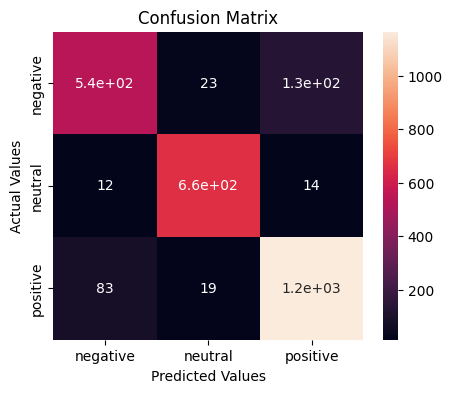

In [17]:
cm = confusion_matrix(y_test, test, labels=["negative", "neutral", "positive"])

cm_df = pd.DataFrame(cm,
                     index =["negative", "neutral", "positive"],
                     columns =["negative", "neutral", "positive"])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Cross Validation

In [18]:
X = df[["Tweet_Clean"]] # input feature
Y = df["Label"] # output feature

# split dataset to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

X_train = X_train.reset_index().Tweet_Clean
y_train = y_train.reset_index().Label

y = classes

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    clf = MLPClassifier()
    clf.fit(data_train, target_train)

    preds = clf.predict(data_test)
    
    accuracy = accuracy_score(target_test,preds)
    
    print("Training ke-", iteration)
    print(classification_report(target_test,preds, zero_division=0))
    print("========================================================")

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

In [19]:
# cross validation dengan split = 5
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies=[]

X_train = X_train.reset_index().Tweet_Clean
y_train = y_train.reset_index().Label

In [20]:
def cross_validation(k, X_train, model, name):
  accuracies = []
  precisions = []
  recalls = []
  f1_scores = []

  # iterate sebanyak k cross validation
  for iteration, data in enumerate(kf.split(X_train), start=1):
      # get data and target train
      data_train = X_train[data[0]]
      tfidf_vect = TfidfVectorizer()
      data_train = tfidf_vect.fit_transform(data_train)

      target_train = y_train[data[0]]

      # get data and target test
      data_test =  X_train[data[1]]
      data_test = tfidf_vect.transform(data_test)

      target_test =  y_train[data[1]]

      # model training menggunakan data train
      classifier = model
      classifier.fit(data_train, target_train)

      # prediksi data test
      preds = classifier.predict(data_test)

      # menghitung accuracy
      accuracy = accuracy_score(target_test, preds)
      precision = precision_score(target_test, preds, average='weighted')
      recall = recall_score(target_test, preds, average='weighted')
      f1 = f1_score(target_test, preds, average='weighted')

      # print("Training ke-", iteration)
      # print(classification_report(target_test, preds))
      # print("=================================================================")

      accuracies.append(accuracy)
      precisions.append(precision)
      recalls.append(recall)
      f1_scores.append(f1)

  result = {'algorithm': name,
                'accuracy_per_iter': accuracies, 'accuracy_mean': mean(accuracies), 'accuracy_std': stdev(accuracies),
                'recall_mean': mean(recalls),'precision_mean': mean(precisions), 'f1_mean': mean(f1_scores)}
  return result

In [21]:
result = cross_validation(5, X_train, MLPClassifier(), 'Neural Network')
result

{'algorithm': 'Neural Network',
 'accuracy_per_iter': [0.881211547562707,
  0.8873639375295788,
  0.8864174159962139,
  0.8717463322290582,
  0.8783719829626124],
 'accuracy_mean': 0.8810222432560341,
 'accuracy_std': 0.006372346825920469,
 'recall_mean': 0.8810222432560341,
 'precision_mean': 0.8795627617842416,
 'f1_mean': 0.8798224337563073}

## Prediksi Data Baru

In [ ]:
input_text = "aduh jadi mahasiswa jangan sombong dong"

# normalize text
text = tfidf_vect.transform([cleansing(input_text)])

# predict data baru menggunakan model yang telah dibuat
result = model.predict(text)[0]

print("Sentiment:", result)